# 샹들리에 청산과 요요 청산

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
import os
import sys
sys.path.append("C:\\DualMomentum\\BackTesting")
from Library import FinanceLibrary as fl

In [2]:
df = pd.read_csv("..\\Data\\KODEX200_data.csv", encoding="utf-8", engine="python")

In [3]:
df.index = pd.to_datetime(df["Date"])
df = df[["High","Low","Close"]]

df["ATR"] = fl.ATR(df["High"],df["Low"],df["Close"],14)
#atr = fl.ATR(df["High"],df["Low"],df["Close"],14)
#atr.name = "ATR"
#df = pd.concat([df,atr],axis=1)

##### 윈도우 값

In [4]:
win = 20

#### ATR배수값

In [5]:
# ATR 배수값
C_ATR = 3
# 요요청산 배수값
Y_ATR = 2

In [6]:
# 진입 Flag
Entry = 0  # "1"이면 진입

df["Max"] = df["Close"].rolling(window=win,min_periods=1).max()
df["Min"] = df["Close"].rolling(window=win,min_periods=1).min()

# MaxHigh는 샹들리에 청산에서 청산 가격이 됨
df["MaxHigh"] = df["Max"] - df["ATR"] * C_ATR
df["MaxHighExit"] = np.where(df["Low"] < df["MaxHigh"],1,0)
# MinLow는 Trailing Stop에서 청산 가격이 됨
df["MinLow"] = df["Min"] + df["ATR"] * C_ATR
df["MinLowExit"] = np.where(df["Low"] < df["MinLow"],1,0)

df["ATR_Close 비율(%)"] = np.round(df["ATR"]/df["Close"] * 100,2)

# 요요 청산
df["Yoyo"] = df["Close"].shift(1) - df["ATR"] * Y_ATR
df["YoyoExit"] = np.where(df["Low"] < df["Yoyo"],2,0)

In [7]:
df.head()

,High,Low,Close,ATR,Max,Min,MaxHigh,MaxHighExit,MinLow,MinLowExit,ATR_Close 비율(%),Yoyo,YoyoExit
Date,,,,,,,,,,,,,
2010-01-04,19926,19773,19904,NaN,19904.0,19904.0,NaN,0,NaN,0,NaN,NaN,0
2010-01-05,19971,19830,19885,152.0,19904.0,19885.0,19448.0,0,20341.0,1,0.76,19600.0,0
2010-01-06,20055,19909,20022,148.0,20022.0,19885.0,19578.0,0,20329.0,1,0.74,19589.0,0
2010-01-07,20036,19765,19774,162.0,20022.0,19774.0,19536.0,0,20260.0,1,0.82,19698.0,0
2010-01-08,19865,19605,19850,189.0,20022.0,19774.0,19455.0,0,20341.0,1,0.95,19396.0,0


In [8]:
df = df["2019"]
#df = df["2015-01":"2015-03"]
#df = df["2015-01"]
DD, MDD = fl.MDD(df["Close"])

##### 청산전략 실행횟수

In [9]:
print ("Trailing Stop 청산 횟수(또는 유지)는{}이다".format(df["MinLowExit"][df["MinLowExit"]>=1].count()))
print ("Chandelier Stop 청산 횟수(또는 유지)는{}이다".format(df["MaxHighExit"][df["MaxHighExit"]>=1].count()))
print ("YoYo 청산 횟수는{}이다".format(df["YoyoExit"][df["YoyoExit"]>=1].count()))

Trailing Stop 청산 횟수(또는 유지)는28이다
Chandelier Stop 청산 횟수(또는 유지)는14이다
YoYo 청산 횟수는0이다


##### 그래프

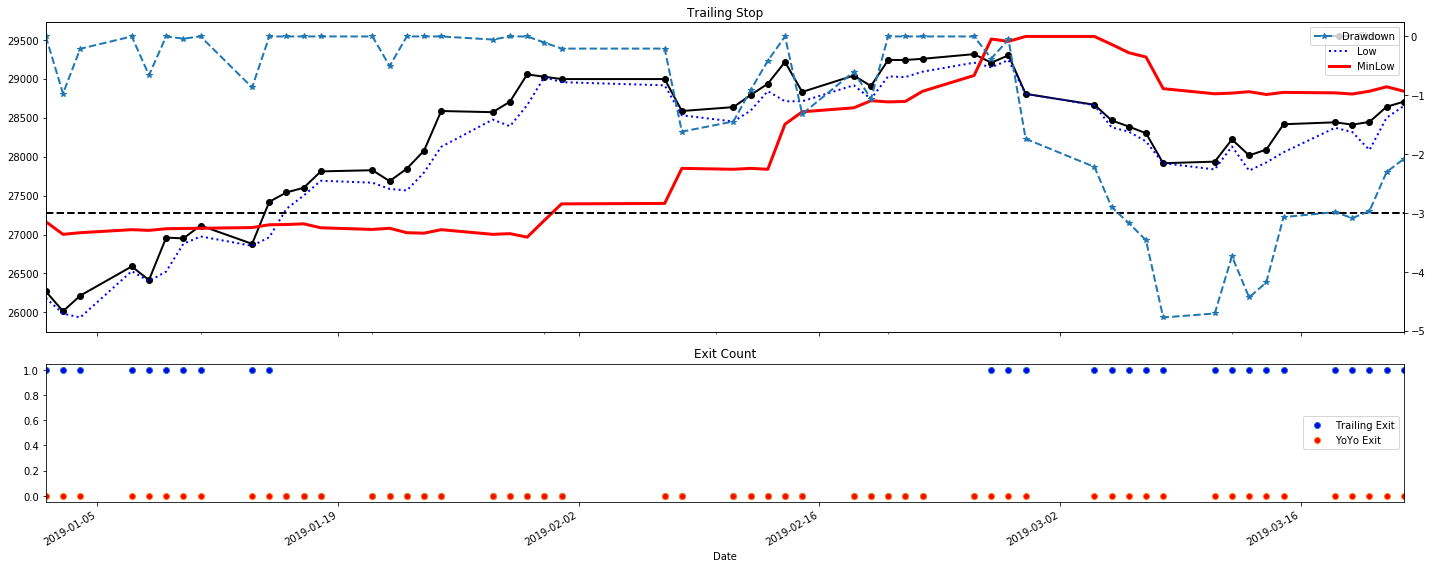

In [12]:
%matplotlib inline
import matplotlib.pylab as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.color'] = 'Black'
plt.rcParams['axes.grid'] = False 

fig = plt.figure()
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=2)
ax1.set_title("Trailing Stop")
# MyFormatter
formatter = fl.MyFormatter(df.index)
ax1.xaxis.set_major_formatter(formatter)

df["Close"].plot(color="Black",label="Close",marker="o")
df["Low"].plot(linestyle=":",color="Blue", label="Low")
df["MinLow"].plot(color="Red", label="MinLow", linewidth="3")
plt.legend(loc="best")

tw_ax1 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
DD.plot(linestyle="--", marker="*")
tw_ax1.hlines(linestyle="--",y=-3,xmin=DD.index[0],xmax=DD.index[-1])
plt.legend(loc="best")

ax2 = plt.subplot2grid((3,1),(2,0))
ax2.set_title("Exit Count")
# MyFormatter
formatter = fl.MyFormatter(df.index)
ax1.xaxis.set_major_formatter(formatter)

df["MinLowExit"].plot(marker='o',markerfacecolor='blue',linestyle="",label="Trailing Exit")
df["YoyoExit"].plot(marker='o',markerfacecolor='Red',linestyle="",label="YoYo Exit")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()

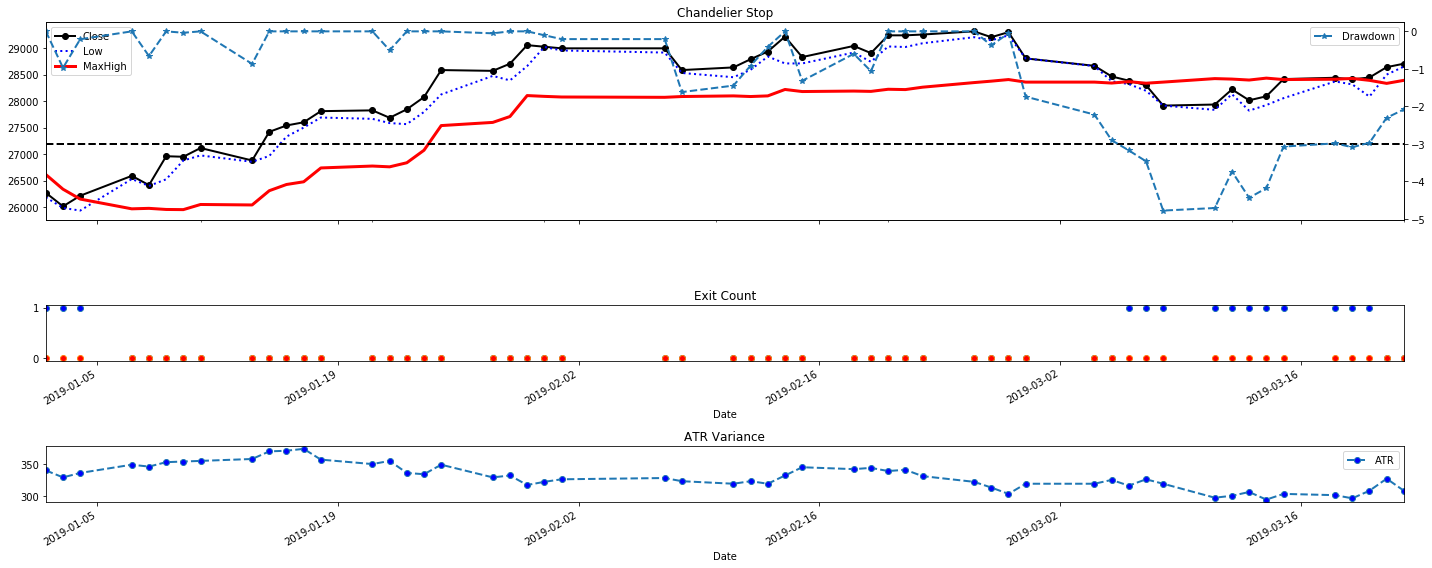

In [11]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.color'] = 'Black'
plt.rcParams['axes.grid'] = False 

fig = plt.figure()
ax1 = plt.subplot2grid((4,1),(0,0),rowspan=2)
ax1.set_title("Chandelier Stop")
df["Close"].plot(color="Black",label="Close",marker="o")
df["Low"].plot(linestyle=":",color="Blue", label="Low")
df["MaxHigh"].plot(color="Red", label="MaxHigh", linewidth="3")
plt.legend()

tw_ax1 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
DD.plot(linestyle="--", marker="*")
tw_ax1.hlines(linestyle="--",y=-3,xmin=DD.index[0],xmax=DD.index[-1])
plt.legend()

ax2 = plt.subplot2grid((4,1),(2,0))
ax2.set_title("Exit Count")
df["MaxHighExit"].plot(marker='o',markerfacecolor='blue',linestyle="",label="Chandelier Exit")
df["YoyoExit"].plot(marker='o',markerfacecolor='Red',linestyle="",label="YoYo Exit")

ax3 = plt.subplot2grid((4,1),(3,0))
ax3.set_title("ATR Variance")
df["ATR"].plot(marker='o',markerfacecolor='blue',linestyle="--",label="ATR")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()